In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

from mplsoccer import Pitch, FontManager
from mplsoccer.statsbomb import read_event, EVENT_SLUG

In [2]:
MATCH_ID = 8658
TEAM = 'France'
OPPONENT = 'vs Croatia, FIFA World Cup 2018 Final'
#load data from Statsbomb API
event_dict = read_event(f'{EVENT_SLUG}/{MATCH_ID}.json', warn=False)
players = event_dict['tactics_lineup']
events = event_dict['event']

In [6]:
#Add tactics id and formation to event
events.loc[events.tactics_formation.notnull(), 'tactics_id'] = events.loc[
    events.tactics_formation.notnull(), 'id']
events[['tactics_id', 'tactics_formation']] = events.groupby('team_name')[[
    'tactics_id', 'tactics_formation']].ffill()

In [9]:
#Assign player postion to players
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
players['position_abbreviation'] = players.player_position_id.map(formation_dict)

In [12]:
#Adding substition players in whilst no change in formation
sub = events.loc[events.type_name == 'Substitution',
                 ['tactics_id', 'player_id', 'substitution_replacement_id',
                  'substitution_replacement_name']]
players_sub = players.merge(sub.rename({'tactics_id': 'id'}, axis='columns'),
                            on=['id', 'player_id'], how='inner', validate='1:1')
players_sub = (players_sub[['id', 'substitution_replacement_id', 'position_abbreviation']]
               .rename({'substitution_replacement_id': 'player_id'}, axis='columns'))
players = pd.concat([players, players_sub])
players.rename({'id': 'tactics_id'}, axis='columns', inplace=True)
players = players[['tactics_id', 'player_id', 'position_abbreviation']]

In [13]:
# add position of players to the events dataframe
events = events.merge(players, on=['tactics_id', 'player_id'], how='left', validate='m:1')
# addposition of receipient to the events dataframe
events = events.merge(players.rename({'player_id': 'pass_recipient_id'},
                                     axis='columns'), on=['tactics_id', 'pass_recipient_id'],
                      how='left', validate='m:1', suffixes=['', '_receipt'])

In [15]:
#formation used in the match
events.groupby('team_name').tactics_formation.unique()

team_name
Croatia    [433.0]
France     [442.0]
Name: tactics_formation, dtype: object

In [31]:
FORMATION = 442
pass_cols = ['id', 'position_abbreviation', 'position_abbreviation_receipt']
passes_formation = events.loc[(events.team_name == TEAM) & (events.type_name == 'Pass') &
                              (events.tactics_formation == FORMATION) &
                              (events.position_abbreviation_receipt.notnull()), pass_cols].copy()
location_cols = ['position_abbreviation', 'x', 'y']
location_formation = events.loc[(events.team_name == TEAM) &
                                (events.type_name.isin(['Pass', 'Ball Receipt'])) &
                                (events.tactics_formation == FORMATION), location_cols].copy()

# average locations of each player
average_locs_and_count = (location_formation.groupby('position_abbreviation')
                          .agg({'x': ['mean'], 'y': ['mean', 'count']}))
average_locs_and_count.columns = ['x', 'y', 'count']

# calculate the number of passes between each position (using min/ max so we get passes both ways)
passes_formation['pos_max'] = (passes_formation[['position_abbreviation',
                                                'position_abbreviation_receipt']]
                               .max(axis='columns'))
passes_formation['pos_min'] = (passes_formation[['position_abbreviation',
                                                'position_abbreviation_receipt']]
                               .min(axis='columns'))
passes_between = passes_formation.groupby(['pos_min', 'pos_max']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True) 

# add location of each player
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_min', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_max', right_index=True,suffixes=['', '_end'])

passes_formation.head()

,id,position_abbreviation,position_abbreviation_receipt,pos_max,pos_min
65,95f14d96-c748-411a-ab65-e6de890e0651,RB,LDM,RB,LDM
69,80813884-4cf0-494d-aa5f-cd524a95d240,LDM,RDM,RDM,LDM
77,6a2fe4f0-d5cf-4628-9752-fb57e2b35516,RCF,RM,RM,RCF
83,cbdbd46a-512b-4b73-b84a-7a9cd146d54d,RB,RCB,RCB,RB
86,246e34e4-e17f-4727-8c66-c025c9435353,RCB,GK,RCB,GK


In [33]:
#Customize line width according to successful passes made count
MAX_LINE_WIDTH = 18
MAX_MARKER_SIZE = 3000
passes_between['width'] = (passes_between.pass_count / passes_between.pass_count.max() *
                           MAX_LINE_WIDTH)
average_locs_and_count['marker_size'] = (average_locs_and_count['count']
                                         / average_locs_and_count['count'].max() * MAX_MARKER_SIZE)

#set line transparency
MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('white'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

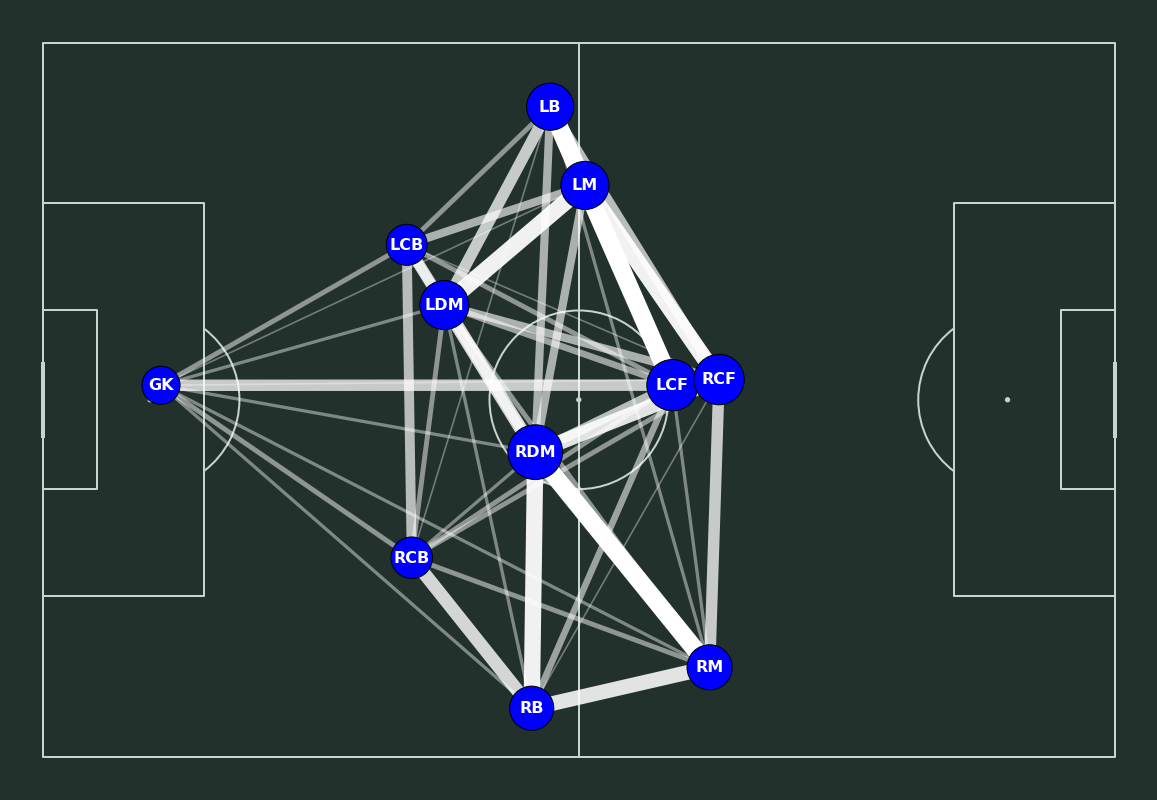

In [35]:
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor("#22312b")
pass_lines = pitch.lines(passes_between.x, passes_between.y,
                         passes_between.x_end, passes_between.y_end, lw=passes_between.width,
                         color=color, zorder=1, ax=ax)
pass_nodes = pitch.scatter(average_locs_and_count.x, average_locs_and_count.y,
                           s=average_locs_and_count.marker_size,
                           color='blue', edgecolors='black', linewidth=1, alpha=1, ax=ax)
for index, row in average_locs_and_count.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)

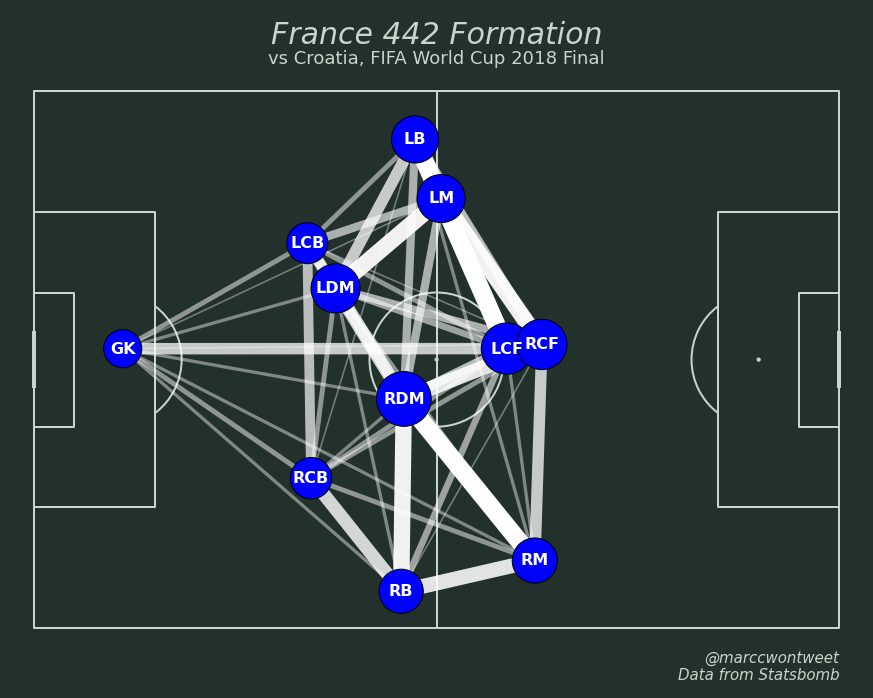

In [52]:
fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0,
                      axis=False,
                      title_space=0, grid_height=0.82, endnote_height=0.05)
fig.set_facecolor("#22312b")
pass_lines = pitch.lines(passes_between.x, passes_between.y,
                         passes_between.x_end, passes_between.y_end, lw=passes_between.width,
                         color=color, zorder=1, ax=axs['pitch'])
pass_nodes = pitch.scatter(average_locs_and_count.x, average_locs_and_count.y,
                           s=average_locs_and_count.marker_size,
                           color='blue', edgecolors='black', linewidth=1, alpha=1, ax=axs['pitch'])
for index, row in average_locs_and_count.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=axs['pitch'])

# endnote title
axs['endnote'].text(1, 0.9, '@marccwontweet', color='#c7d5cc',
                    va='center', ha='right', fontsize=15, fontstyle='italic')
axs['endnote'].text(1, 0.45, 'Data from Statsbomb', color='#c7d5cc',
                    va='center', ha='right', fontsize=15, fontstyle='italic')
TITLE_TEXT = f'{TEAM} {FORMATION} Formation'
axs['title'].text(0.5, 0.5, TITLE_TEXT, color='#c7d5cc',
                  va='center', ha='center', fontsize=30, fontstyle='oblique')
axs['title'].text(0.5, 0.10, OPPONENT, color='#c7d5cc',
                  va='center', ha='center', fontsize=18)

plt.savefig('PassNet_WCFinal2018',dpi=300,bbox_inches = 'tight',facecolor='#22312b')